In [ ]:
#read data
from google.colab import files 
files.upload() 


#from google.colab import drive
#drive.mount('/content/drive')

In [ ]:
#import os 
#os.chdir('/content/drive/My Drive/')
#print(os.listdir())

%ls

In [ ]:

import pandas as pd
import os 

#read dataset
dataset = pd.read_csv('all-data.csv',encoding = "ISO-8859-1")
dataset.head()

In [ ]:
# one hot encoding the class
sentiment = pd.get_dummies(dataset['class'])
dataset = pd.concat([dataset, sentiment], axis=1)
dataset= dataset.drop(columns='class')



In [ ]:

#copy theo riginal 
dataset['og_news'] = dataset['news']

#lower text 
dataset['news'] = dataset['news'].str.lower()


# remove punctuation 
dataset['news'] = dataset['news'].str.replace('[^\w\s]','')
dataset.head()


# remove stopwords 
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop = stopwords.words('english')
dataset['news'] = dataset['news'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))




#stemming 
from nltk.stem import PorterStemmer 
ps = PorterStemmer() 

#remove link and only take alpha numeric value 
import re 
pattern = re.compile('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
for i, row in dataset.iterrows():
    textNow = row.news
    textCleaned = pattern.sub('', str(textNow) )
    textCleaned = re.sub('[^0-9a-zA-Z]+', ' ', textCleaned)

    #PorterStemmer
    stemmedSentence  = ""
    for word in textCleaned.split(" "):
      stemmedSentence = stemmedSentence + ps.stem(word) + " "

    # Remove Number 
    stemmedSentence = re.sub(r"\d+", "", stemmedSentence)
    dataset.at[i,'news'] =  stemmedSentence


#dataset.to_csv('all-data_cleaned.csv')
#files.download('all-data_cleaned.csv')


In [ ]:
dataset.head()

In [ ]:
#divide between news as attribute and sentiment as a class
news = dataset['news'].values 
label= dataset[['negative' , 'neutral','positive']]

In [ ]:
from sklearn.model_selection import train_test_split 
attribute_train , attribute_test , label_train , label_test = train_test_split(news,label,test_size = 0.2)

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
 
tokenizer = Tokenizer(num_words=1000)
tokenizer.fit_on_texts(attribute_train) 
tokenizer.fit_on_texts(attribute_test)
 
sequence_train = tokenizer.texts_to_sequences(attribute_train)
sequence_test = tokenizer.texts_to_sequences(attribute_test)
 
pad_train = pad_sequences(sequence_train) 
pad_test = pad_sequences(sequence_test)

In [ ]:
import tensorflow as tf
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=1000, output_dim=16),
    tf.keras.layers.SpatialDropout1D(0.8),
    #tf.keras.layers.LSTM(64,return_sequences=True),
    tf.keras.layers.LSTM(16, dropout=0.1 ),
    #tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    #tf.keras.layers.Dense(3, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [ ]:
dataset.head()

In [ ]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('val_accuracy')>0.75):
      print("\nAkurasi telah mencapai >= 85%!")
      self.model.stop_training = True
callbacks = myCallback()

In [ ]:
history = model.fit(pad_train, label_train, epochs=40,
                    validation_data=(pad_test, label_test), verbose=2, callbacks= [callbacks])

Epoch 1/40
122/122 - 2s - loss: 0.9329 - accuracy: 0.5952 - val_loss: 0.8852 - val_accuracy: 0.5897
Epoch 2/40
122/122 - 2s - loss: 0.8401 - accuracy: 0.6349 - val_loss: 0.8159 - val_accuracy: 0.6371
Epoch 3/40
122/122 - 2s - loss: 0.7732 - accuracy: 0.6731 - val_loss: 0.7754 - val_accuracy: 0.6474
Epoch 4/40
122/122 - 2s - loss: 0.7345 - accuracy: 0.6907 - val_loss: 0.7610 - val_accuracy: 0.6649
Epoch 5/40
122/122 - 2s - loss: 0.7180 - accuracy: 0.6999 - val_loss: 0.7435 - val_accuracy: 0.6773
Epoch 6/40
122/122 - 2s - loss: 0.6927 - accuracy: 0.7036 - val_loss: 0.7302 - val_accuracy: 0.6794
Epoch 7/40
122/122 - 2s - loss: 0.6699 - accuracy: 0.7245 - val_loss: 0.7358 - val_accuracy: 0.6814
Epoch 8/40
122/122 - 2s - loss: 0.6769 - accuracy: 0.7149 - val_loss: 0.7528 - val_accuracy: 0.6814
Epoch 9/40
122/122 - 2s - loss: 0.6681 - accuracy: 0.7188 - val_loss: 0.7475 - val_accuracy: 0.6814
Epoch 10/40
122/122 - 2s - loss: 0.6467 - accuracy: 0.7312 - val_loss: 0.7527 - val_accuracy: 0.6866

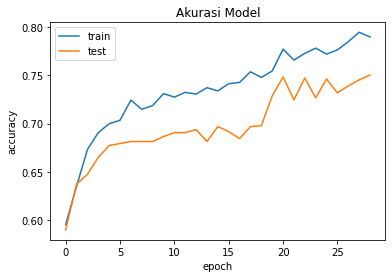

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Akurasi Model')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

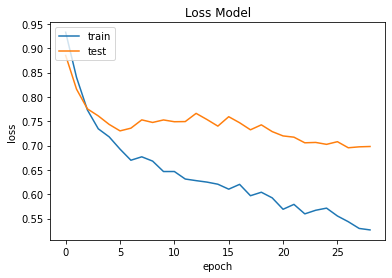

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss Model')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()